# Stock Analysis Utilizing Google Search Analytics
#### Group Members: Andrew Turvey, Arielle Swift, Connor Moore, Dan Knobloch,  Ken Cupples, Shawn Sonnack 
BAIS 6040: Data Programming in Python <br>
Group 01 <br>
3 August 2021 <br>

## Problem and Goal Statement:
   The recent rise of retail investors and day traders, as seen in news stories pertaining to GameStop and AMC, coupled with the increase in internet usage for research, and general information sharing purposes over the last 20 years poses an interesting question as to how stock price and search engine hits (such as Google searches) are tied together. More specifically our team analyzed how a desired company’s closing stock price can be affected by “Google Trends” search interest data to see if there is a strong enough correlation to build a model that would accurately predict a price increase for a given day and therefore could generate a “buy signal” for traders.
	
   Factors of importance needed to develop an acceptable model will include: previous day’s share price, volume of shares trade, and Google Trends search history score, which is a number between 0-100 that is base lined  off of the highest search interest day in a given time period. Data can be pulled direct from most finance sites and the Google Trend website. We then added a few manually calculated relationship fields, such as whether or not the price or trend increases the previous day to enhance our models. Our model will be built and trained primarily on data from Q2 in calendar year 2021 (April 01 – June 30) and will be tested on July 2021 data. The models performance will be easily analyzed by comparing the predicted values to the actual values. 


## Import

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
from datetime import date
from datetime import timedelta
from pytrends.request import TrendReq
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split    # For generating test/train
from sklearn.linear_model import LinearRegression   # Logistic regression

%matplotlib inline

## Global Variables and Initialization

In [7]:
dataDir = r"./Data Files/"  #Directory of all data
today = date.today()  # Todays date
rnd.seed(1024)

## Global Functions

In [8]:
# Function gets stock data and trend data if needed
def getData(stockName):
    if os.path.exists(f"{dataDir}{stockName}_{today}_year.csv"):
        #Get stored data
        storedData = pd.read_csv(f"{dataDir}{stockName}_{today}_year.csv")
        # Get rid of index name
        storedData.set_index('Unnamed: 0', inplace=True)
        storedData.index.name = None
        return storedData
    else:
        #Get new data
        # Connect to Google API
        pytrends = TrendReq(hl='en-US', tz=360)
        # Set Keyword
        kw_list = [stockName]
        # Google API only shows last 90 days so need to itirate
        # Set start of interval
        date90Front = date.today()
        # Initiate dataframe
        trendData = pd.DataFrame()
        for _ in range(4):
            # Set start end of interval
            date90Back = date90Front - timedelta(days=90)
            # Build Payload of 90 days
            pytrends.build_payload(kw_list,
                                   timeframe=f'{date90Back} {date90Front}',
                                   geo='')
            trend90 = pytrends.interest_over_time()
            trendData = pd.concat([trend90, trendData])
            date90Front = date90Back
        # Get Stock Data
        stockData = yf.download(stockName,
                                 start=date.today() - timedelta(days=360),
                                 end=date.today(), interval="1d")
        # Combine Data
        newData = stockData.join(trendData)
        # Create index and add date column
        newData.reset_index(inplace=True)
        newData.rename(columns= {"index":"Date"}, inplace = True)
        # Rename search interest
        newData.rename(columns = {stockName: "Search Interest"},inplace = True)
        # Add difference
        newData["Price Difference"] = newData["Close"] - newData["Open"]
        # Add truth value that determines if we want to buy or not that day
        newData['Buy'] = np.where(newData['Price Difference'] > 0, 1, 0)
        # Delete isPartial
        del newData['isPartial']
        # Remove NaN
        newData.dropna(inplace=True)
        # Export to data folder
        newData.to_csv(f"{dataDir}{stockName}_{today}_year.csv")
        return newData

# Function prints metrics of regression model
def printMetricsRegression(test, predictionsResult):
    print(f"Score: {explained_variance_score(test, predictionsResult):.2f}")
    print(f"MAE: {mean_absolute_error(test, predictionsResult):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(test, predictionsResult)):.2f}")
    print(f"r2: {r2_score(test, predictionsResult):.2f}")

## Stock to Analyze

In [9]:
# Stock to analyze

# Gets Data for last year
stockSearchDf = getData("AMZN")
# Set date as index
stockSearchDf.set_index("Date", inplace=True)
# Add rename
stockSearchDf.index = pd.to_datetime(stockSearchDf.index)
stockSearchDf.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy
Date,,,,,,,,,
2020-08-03,3180.510010,3184.000000,3104.000000,3111.889893,3111.889893,5074700,55.0,-68.620117,0
2020-08-04,3101.209961,3167.239990,3101.209961,3138.830078,3138.830078,4694300,49.0,37.620117,1
2020-08-05,3143.770020,3213.590088,3127.300049,3205.030029,3205.030029,3916500,47.0,61.260010,1
2020-08-06,3194.360107,3247.469971,3165.429932,3225.000000,3225.000000,3940600,57.0,30.639893,1
2020-08-07,3224.010010,3240.810059,3140.669922,3167.459961,3167.459961,3936100,51.0,-56.550049,0


,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy
Date,,,,,,,,,
2020-08-03,3180.510010,3184.000000,3104.000000,3111.889893,3111.889893,5074700,55.0,-68.620117,0
2020-08-04,3101.209961,3167.239990,3101.209961,3138.830078,3138.830078,4694300,49.0,37.620117,1
2020-08-05,3143.770020,3213.590088,3127.300049,3205.030029,3205.030029,3916500,47.0,61.260010,1
2020-08-06,3194.360107,3247.469971,3165.429932,3225.000000,3225.000000,3940600,57.0,30.639893,1
2020-08-07,3224.010010,3240.810059,3140.669922,3167.459961,3167.459961,3936100,51.0,-56.550049,0


## Analytics Model: Linear Regression

In [10]:
featureColumns = ['Search Interest', 'Open']
targetColumn = 'Close'

X = stockSearchDf[featureColumns]
y = stockSearchDf[targetColumn]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, shuffle=False)

#### Create the regression

In [11]:
lr = LinearRegression()
lr

LinearRegression()

#### Fit Linear Model

In [12]:
lr.fit(X_train, y_train)

LinearRegression()

#### Our Confidence in our model is high

In [13]:
lr.score(X_train, y_train) 

0.8551111157753216

In [14]:
lr.score(X_test, y_test) 

0.6868910895267177

lr.score(X_test, y_test) 

#### Print the prediction believed accuracy using the model

In [15]:
predictions = lr.predict(X_test)
printMetricsRegression(y_test, predictions)

Score: 0.79
MAE: 44.20
RMSE: 59.88
r2: 0.69


#### Test model using LastMonth data

In [16]:
lastMonthColumns = ["Search Interest","Open","Close"]
lastMonthDf = stockSearchDf[lastMonthColumns].loc[X_test.index]
lastMonthDf["Predicted Close"] = predictions
lastMonthDf.head(5)

,Search Interest,Open,Close,Predicted Close
Date,,,,
2021-06-25,27.0,3464.000000,3401.459961,3448.053695
2021-06-28,22.0,3416.000000,3443.889893,3405.105550
2021-06-29,21.0,3438.820068,3448.139893,3426.649903
2021-06-30,26.0,3441.060059,3440.159912,3427.064785
2021-07-01,25.0,3434.610107,3432.969971,3421.403080


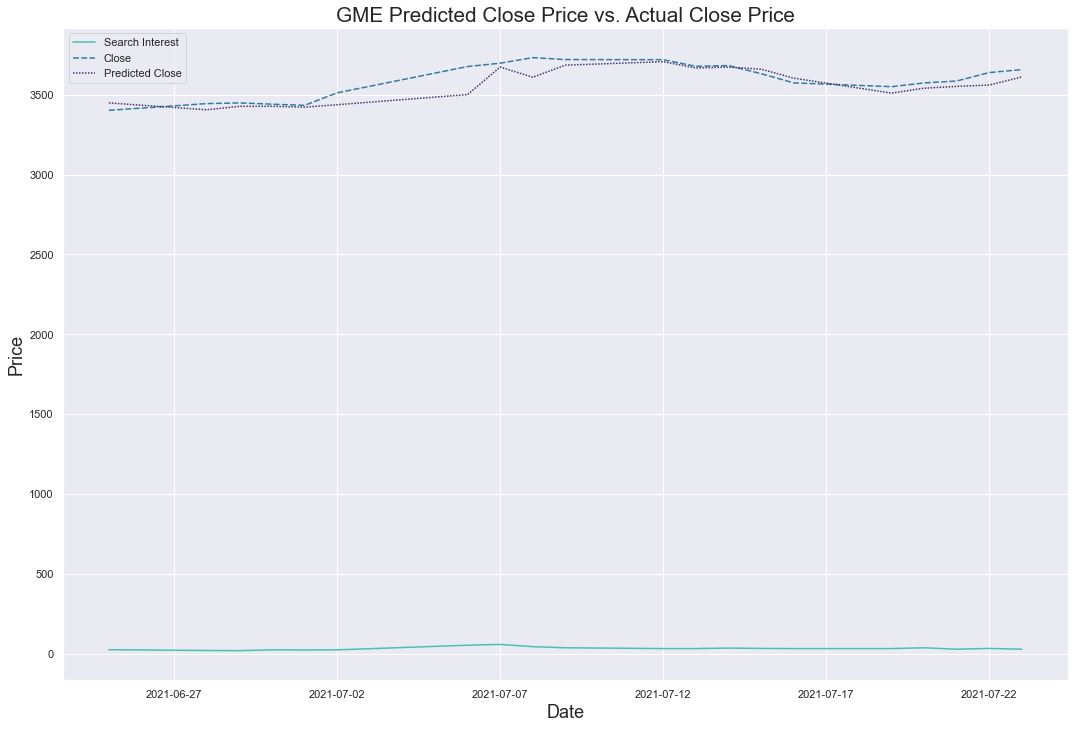

In [17]:
sns.set_theme(style = "darkgrid")
palette = sns.color_palette("mako_r", 3)
fig, ax = plt.subplots(figsize = (18,12))
fig = sns.lineplot(data=lastMonthDf[["Search Interest","Close","Predicted Close"]],
                   ax = ax, palette = palette)

# Add title and axis labels
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.title("GME Predicted Close Price vs. Actual Close Price",
          fontsize = 'xx-large')
ax.xaxis.set_major_locator(mp.ticker.MultipleLocator(5))

# Add legend
plt.legend()

# Display plot
plt.show() 

## Analytics Model 2 w/ Plots

In [18]:
stockSearchDf['Previous Open'] = stockSearchDf['Open'].shift(1)
stockSearchDf['Previous High'] = stockSearchDf['High'].shift(1)
stockSearchDf['Previous Low'] = stockSearchDf['Low'].shift(1)
stockSearchDf['Previous Close'] = stockSearchDf['Close'].shift(1)
stockSearchDf['Previous Adj Close'] = stockSearchDf['Adj Close'].shift(1)
stockSearchDf['Previous Volume'] = stockSearchDf['Volume'].shift(1)
stockSearchDf['Previous Search Interest'] = stockSearchDf['Search Interest'].shift(1)
stockSearchDf.dropna(inplace=True)

stockSearchDf.head(5)

,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy,Previous Open,Previous High,Previous Low,Previous Close,Previous Adj Close,Previous Volume,Previous Search Interest
Date,,,,,,,,,,,,,,,,
2020-08-04,3101.209961,3167.239990,3101.209961,3138.830078,3138.830078,4694300,49.0,37.620117,1,3180.510010,3184.000000,3104.000000,3111.889893,3111.889893,5074700.0,55.0
2020-08-05,3143.770020,3213.590088,3127.300049,3205.030029,3205.030029,3916500,47.0,61.260010,1,3101.209961,3167.239990,3101.209961,3138.830078,3138.830078,4694300.0,49.0
2020-08-06,3194.360107,3247.469971,3165.429932,3225.000000,3225.000000,3940600,57.0,30.639893,1,3143.770020,3213.590088,3127.300049,3205.030029,3205.030029,3916500.0,47.0
2020-08-07,3224.010010,3240.810059,3140.669922,3167.459961,3167.459961,3936100,51.0,-56.550049,0,3194.360107,3247.469971,3165.429932,3225.000000,3225.000000,3940600.0,57.0
2020-08-10,3170.310059,3172.510010,3101.520020,3148.159912,3148.159912,3167300,54.0,-22.150146,0,3224.010010,3240.810059,3140.669922,3167.459961,3167.459961,3936100.0,51.0


In [19]:
columns = ["Previous Open", "Previous High", "Previous Low", "Previous Close", "Previous Volume", "Previous Search Interest", "Close"]
stockSearchDf = stockSearchDf[columns]

stockSearchDf.head(5)

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Close
Date,,,,,,,
2020-08-04,3180.510010,3184.000000,3104.000000,3111.889893,5074700.0,55.0,3138.830078
2020-08-05,3101.209961,3167.239990,3101.209961,3138.830078,4694300.0,49.0,3205.030029
2020-08-06,3143.770020,3213.590088,3127.300049,3205.030029,3916500.0,47.0,3225.000000
2020-08-07,3194.360107,3247.469971,3165.429932,3225.000000,3940600.0,57.0,3167.459961
2020-08-10,3224.010010,3240.810059,3140.669922,3167.459961,3936100.0,51.0,3148.159912


In [20]:
features = list(stockSearchDf.columns)
features.remove("Close")
target = "Close"

X = stockSearchDf[features]
y = stockSearchDf[target]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)

In [22]:
lr = LinearRegression()
lr

LinearRegression()

In [23]:
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
lr.score(X_train, y_train)

0.7707072774464114

In [25]:
lr.score(X_test, y_test)

0.8863632313385906

In [26]:
predictions = lr.predict(X_test)
printMetricsRegression(y_test, predictions)


Score: 0.92
MAE: 43.17
RMSE: 57.78
r2: 0.89


In [27]:
predictions = lr.predict(X_test)
predictions

array([3232.48015433, 3256.95530072, 3215.52406941, 3252.62789636,
       3244.83164229, 3270.89953118, 3243.66239368, 3237.96451255,
       3228.44027856, 3237.15994586, 3206.05893766, 3224.81258388,
       3205.83061475, 3271.11824299, 3292.20109705, 3340.24195999,
       3342.1142645 , 3365.29687582, 3369.23316473, 3391.66326087,
       3460.8450687 , 3477.0907969 , 3426.79821798, 3478.27489872,
       3475.99982998, 3417.30216266, 3382.85830306, 3426.75599713,
       3426.50487994, 3432.43384379, 3410.96174427, 3470.67192071,
       3606.7054373 , 3637.3042148 , 3655.44230627, 3659.31980412,
       3651.01232589, 3642.49820729, 3620.10759894, 3573.79899868,
       3535.56416433, 3501.019283  , 3512.87327863, 3530.09630951,
       3586.52196859])

In [28]:
X_test = X_test.copy()
X_test['Predicted Close'] = predictions
X_test.head(5)

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Predicted Close
Date,,,,,,,
2021-05-20,3195.000000,3234.750000,3184.000000,3231.800049,2679700.0,32.0,3232.480154
2021-05-21,3244.399902,3259.679932,3236.179932,3247.679932,2633200.0,34.0,3256.955301
2021-05-24,3250.000000,3256.689941,3197.010010,3203.080078,4104900.0,31.0,3215.524069
2021-05-25,3215.500000,3257.949951,3210.500000,3244.989990,2422800.0,27.0,3252.627896
2021-05-26,3266.669922,3279.820068,3213.760010,3259.050049,3261100.0,31.0,3244.831642


In [29]:
stockPrice = stockSearchDf.rename(columns = {'Close': 'Actual Close'})
predictedPrice = pd.concat([stockPrice, X_test], axis = 1)
predictedPrice.dropna(inplace = True)
predictedPrice.head(5)

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Actual Close,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Predicted Close
Date,,,,,,,,,,,,,,
2021-05-20,3195.000000,3234.750000,3184.000000,3231.800049,2679700.0,32.0,3247.679932,3195.000000,3234.750000,3184.000000,3231.800049,2679700.0,32.0,3232.480154
2021-05-21,3244.399902,3259.679932,3236.179932,3247.679932,2633200.0,34.0,3203.080078,3244.399902,3259.679932,3236.179932,3247.679932,2633200.0,34.0,3256.955301
2021-05-24,3250.000000,3256.689941,3197.010010,3203.080078,4104900.0,31.0,3244.989990,3250.000000,3256.689941,3197.010010,3203.080078,4104900.0,31.0,3215.524069
2021-05-25,3215.500000,3257.949951,3210.500000,3244.989990,2422800.0,27.0,3259.050049,3215.500000,3257.949951,3210.500000,3244.989990,2422800.0,27.0,3252.627896
2021-05-26,3266.669922,3279.820068,3213.760010,3259.050049,3261100.0,31.0,3265.159912,3266.669922,3279.820068,3213.760010,3259.050049,3261100.0,31.0,3244.831642


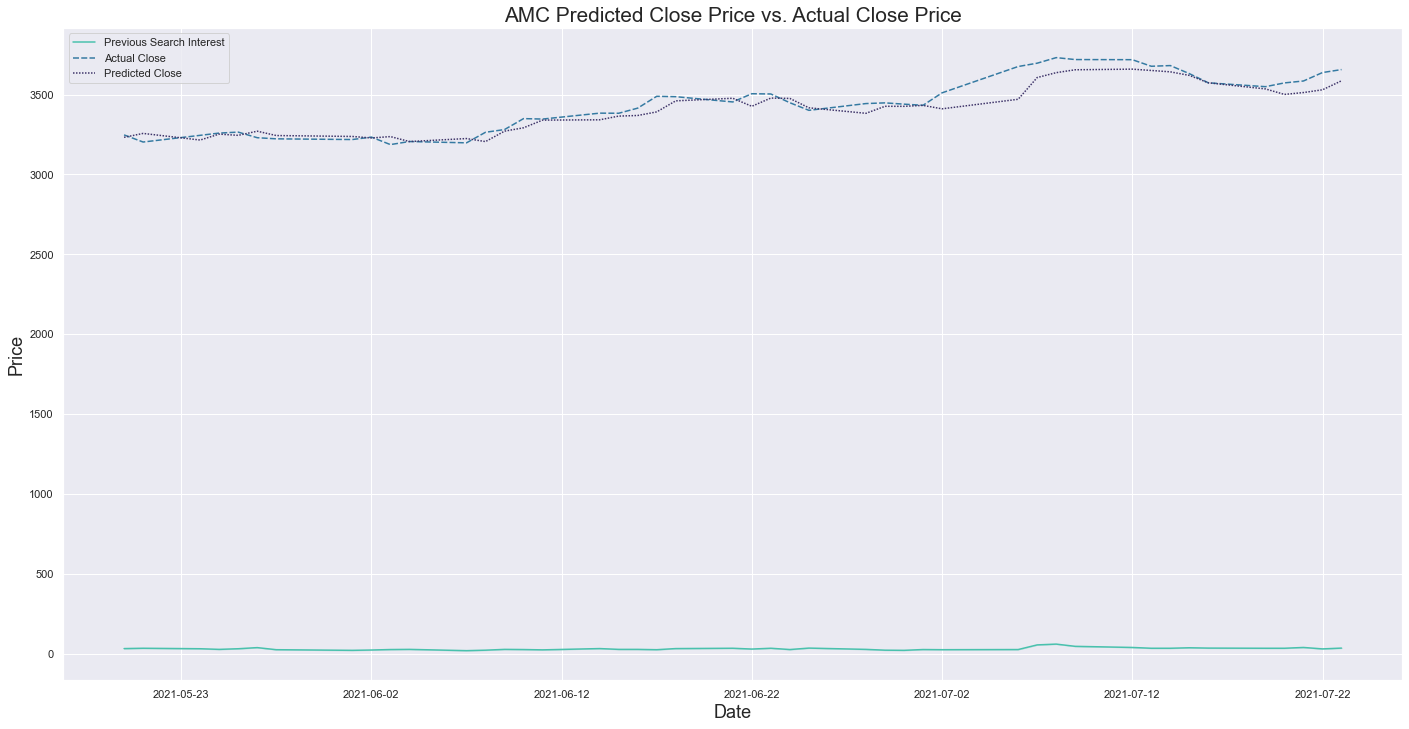

In [30]:
sns.set_theme(style = "darkgrid")
palette = sns.color_palette("mako_r", 3)
fig, ax = plt.subplots(figsize = (24,12))
fig = sns.lineplot(data=predictedPrice[["Previous Search Interest","Actual Close","Predicted Close"]],
                   ax = ax, palette = palette)


#add title and axis labels
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Price", fontsize = 18)
plt.title("AMC Predicted Close Price vs. Actual Close Price",
          fontsize = 'xx-large')
ax.xaxis.set_major_locator(mp.ticker.MultipleLocator(10))

#add legend
plt.legend()

#display plot
plt.show() 

## Conclusion

The two stocks used in this analysis in Game Stop and AMC.  The historic Game Stop data represents a stock with an overall lower average value for Google trends search history score while conversely, AMC indicates a higher average for Google trends search history score.  Historical closing prices were analyzed against the previous days share price, volume traded, and Google trends search history score using linear regression model.  The analysis was used to make predictions about the closing prices for both stocks during the last two months of the second quarter and compare these predictions against the actual stock prices for the same date range by overlaying both trends in the graphs displayed in this report. 


Visually, both stock prices overlay reasonably well with the predicted versus actual stock prices and provide an encouraging view that our factors model the change in the closing stock price over the last two months.   Game Stop performs better overall with a score of .79, a R squared value of .72, root mean square error of 8.05, and mean absolute error of 5.91.  This effectively means 72% of the variation in the closing stock price over the time range can be explained by the factors that were tested.  In general, small values for the MSE and MAE are desirable as this is a measure of the difference between actual values and the predicted model.  The average close price over the year for Game Stop $93.08 making these values less than 10% of the average close price.   AMC performs lower with a score of .52, a R squared value of .43, root mean square error of 25.80, and mean absolute error of 19.23.  With only 43% variation in the close price that can be explained by the tested factors, and average close price of AMC for the year being $12.70 compared to the root mean square error of two times the average price, AMC did not track against the predicted model as well as Game Stop.   Overall, the use of a Google trends search history score combined with previous price history and volume traded looks to be an encouraging indicator of potential stock purchases.

